In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
Vizier.ROW_LIMIT = 50000
from xshooter_synthmag import Filter, synthcolor
import os

/home/dkeyi/anaconda3/envs/astro/lib/python3.12/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/home/dkeyi/anaconda3/envs/astro/lib/python3.12/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


## Loading in x-shooter data

In [2]:
DATA_DIR = 'XSL_DR3_release/XSL_DR3_release/'
#directory of where xshooter files are

#I've picked out a few stars from X-shooter to look at, here I list their names
# and properties
files_list = ['xsl_spectrum_X0422_merged.fits', #relatively metal-rich k-giant star ([Fe/H] ~ 0.2)
             'xsl_spectrum_X0363_merged.fits', #metal-poor k-giant star ([Fe/H] ~ -2.4)
            'xsl_spectrum_X0511_merged.fits', #AGB star ([Fe/H] ~ -0.4)
            'xsl_spectrum_X0044_merged.fits', #M-giant ([Fe/H] ~ -0.1)
            'xsl_spectrum_X0418_merged.fits', #metal-poor, 'chemically peculiar' g-giant ([Fe/H] ~ -2.3)
            'xsl_spectrum_X0162_merged.fits', #metal-rich, g-giant ([Fe/H] ~0.1)
            'xsl_spectrum_X0782_merged.fits', #metal-poor rr lyrae ([Fe/H] ~ -1.7)
            'xsl_spectrum_X0639_merged.fits', #metal-poor BHB ([Fe/H] ~ -1.3)
            'xsl_spectrum_X0390_merged.fits', #k-dwarf ([Fe/H] ~ -0.3)
            'xsl_spectrum_X0831_merged.fits', #f-dwarf ([Fe/H] ~ -0.3)
            'xsl_spectrum_X0382_merged.fits'] #g-dwarf ([Fe/H] ~ -0.4)
name_list = ['metal-rich k-giant',
            'metal-poor k-giant',
            'AGB',
            'm-giant',
            'metal-poor g-giant',
             'metal-rich g-giant',
            'metal-poor RR lyrae',
             'metal-poor BHB',
             'k-dwarf',
            'f-dwarf',
            'g-dwarf']

In [3]:
#lets see what data is in one of the x-shooter files
hdus = fits.open(DATA_DIR+'xsl_spectrum_X0422_merged.fits', memmap=False)
hdus[0].header #hdus[1].header
#from the header, we know that this star is named HD 4893. we can look this star
# up by its name in vizier or simbad
#and get information about its temperature and log(g) 

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
OBJECT  = 'HD004893'           / Machine-readable name of the star              
HNAME   = 'HD 4893 '           / Human-readable name of the star                
XSL_ID  = 'X0422   '           / X-shooter Spectral Library unique identifier   
RA      =    12.34408333333333 / [deg] Spectroscopic target position (J2000)    
DEC     =   -73.47866111111111 / [deg] Spectroscopic target position (J2000)    
RA_FULL = '00:49:22.58'        / [HH:MM:SS.SS] Target position (J2000)          
DEC_FULL= '-73:28:43.18'       / [DD:MM:SS.SS] Target position (J2000)          
EQUINOX =               2000.0 / Standard FK5                                   
RADECSYS= 'FK5     '        

In [4]:
hdus[1].data #the data has wavelength, flux, deredened flux, and error in flux 
#we will want to use the de-reddened flux, i.e. flux_dr

FITS_rec([( 350.     , 1.2775197e-15, 1.2775197e-15, 1.2173860e-13),
          ( 350.0117 , 1.1601396e-13, 1.1601396e-13, 1.2188833e-13),
          ( 350.02335, 9.1615693e-15, 9.1615693e-15, 1.2084570e-13), ...,
          (2476.794  , 1.4761918e-13, 1.4761918e-13, 3.4227975e-15),
          (2476.8765 , 1.3909123e-13, 1.3909123e-13, 3.3573589e-15),
          (2476.959  , 1.3779878e-13, 1.3779878e-13, 3.3491734e-15)],
         dtype=(numpy.record, [('WAVE', '>f4'), ('FLUX', '>f4'), ('FLUX_DR', '>f4'), ('ERR', '>f4')]))

In [5]:
#lets get the table that has all of the stellar atmospheric parameters, we can
#then match the catalogue to our stars and find the log(g), [Fe/H] info for 
#each star
#table is here: https://vizier.cds.unistra.fr/viz-bin/VizieR searching for catalog
# named J/A+A/627/A138/tablea1
table = Vizier.get_catalogs('J/A+A/627/A138/tablea1')
stellar_params = table[0].to_pandas()
stellar_params['Cflag'] #lets see what info we have
Cstars = stellar_params[stellar_params['Cflag']==1]['HNAME']
Cstars = [str(i) for i in Cstars]

In [6]:
stellar_params.columns

Index(['HNAME', 'x', 'Teffuvb', 'logguvb', '__Fe_H_uvb', 'Teffvis', 'loggvis',
       '__Fe_H_vis', 'Teff', 'e_Teff', 'logg', 'e_logg', '__Fe_H_', 'e__Fe_H_',
       'f_Teff', 'f_logg', 'f__Fe_H_', 'Cflag', 'SimbadName', '_RA', '_DE'],
      dtype='object')

In [7]:
#now we can find which entry in the stellar params table matches our stars name
#we'll do this by using .str.contains (to see if stellar param HNAME contains header HNAME, 
# allowing for their to be weird extra spaces etc) or stellar param HNAME == hdu HNAME to check
# for if the HNAMEs are exactly equal!
#note that not /all/ of the stars in x-shooter have a match in this data
stellar_params[(stellar_params['HNAME'].str.contains(hdus[0].header['HNAME']))
            |(stellar_params['HNAME']==hdus[0].header['HNAME'])]['__Fe_H_']

469    0.03
Name: __Fe_H_, dtype: float32

# lets make some synthetic colors!

In [8]:
#loading in our filters
filt_g = Filter()
filt_g.read('fHSC-g.txt')

filt_i = Filter()
filt_i.read('fHSC-i.txt')


filt_nb515 = Filter()
filt_nb515.read('fHSC-NB515.txt')


In [9]:
#synthcolor takes your xshooter data (here hdus[1]), two filters, and deredening
#argument. Here, we want to use dered = True. Synthcolor will return
# the color filter_1 - filter_2
g_i = synthcolor(hdus[1], filt_g, filt_i, dered=True)
nb_g = synthcolor(hdus[1], filt_nb515, filt_g, dered=True)

In [10]:
print('star ', 
    hdus[0].header['HNAME'],
    ' has [Fe/H] of ',
    stellar_params[(stellar_params['HNAME'].str.contains(hdus[0].header['HNAME']))
            |(stellar_params['HNAME']==hdus[0].header['HNAME'])]['__Fe_H_'].values[0],
    ' and log(g) of',
    stellar_params[(stellar_params['HNAME'].str.contains(hdus[0].header['HNAME']))
            |(stellar_params['HNAME']==hdus[0].header['HNAME'])]['logg'].values[0],
    ' and g-i color of ', g_i, ' and NB515 - g color of ',
    nb_g)

star  HD 4893  has [Fe/H] of  0.03  and log(g) of 2.29  and g-i color of  1.4978857698334682  and NB515 - g color of  -0.13520114727715082


In [11]:
#lets do compute colors for all of the stars that we found above, and see where they 
# are on the color-color plots
fehs = np.array([])
teffs = np.array([])
loggs = np.array([])
g_i_color = np.array([])
nb_g_color = np.array([])


for i in range(len(files_list)):
    fn = os.path.join(DATA_DIR, files_list[i])
    hdus = fits.open(fn, memmap=False)
    print('looking at ', name_list[i])
    #get all the stellar param info
    logg = stellar_params[(stellar_params['HNAME'].str.contains(hdus[0].header['HNAME']))
            |(stellar_params['HNAME']==hdus[0].header['HNAME'])].logg.mean()
    loggs = np.append(loggs, logg)
    teff = stellar_params[(stellar_params['HNAME'].str.contains(hdus[0].header['HNAME']))
            |(stellar_params['HNAME']==hdus[0].header['HNAME'])].Teff.mean()
    teffs = np.append(teffs, teff)
    feh = stellar_params[(stellar_params['HNAME'].str.contains(hdus[0].header['HNAME']))
            |(stellar_params['HNAME']==hdus[0].header['HNAME'])]['__Fe_H_'].mean()
    fehs = np.append(fehs, feh)
    #synth_g = synthmagnoR(hdus[1], filt_g, dered=False)
    #synth_i = synthmagnoR(hdus[1], filt_i, dered=False)
    #synth_nb = synthmagnoR(hdus[1], filt_nb515, dered=False)

    g_i = synthcolor(hdus[1], filt_g, filt_i, dered=True)
    nb_g = synthcolor(hdus[1], filt_nb515, filt_g, dered=True)
    g_i_color = np.append(g_i_color, g_i)
    nb_g_color = np.append(nb_g_color, nb_g)
    


looking at  metal-rich k-giant
looking at  metal-poor k-giant
looking at  AGB
first flux value is zero!
looking at  m-giant
first flux value is zero!
looking at  metal-poor g-giant
looking at  metal-rich g-giant
looking at  metal-poor RR lyrae
looking at  metal-poor BHB
looking at  k-dwarf
looking at  f-dwarf
looking at  g-dwarf


In [12]:
fn = os.path.join(DATA_DIR, files_list[1])
hdus = fits.open(fn, memmap=False)
stellar_params[stellar_params['HNAME'].str.contains(hdus[0].header['HNAME'])]#.Teff

stellar_params[(stellar_params['HNAME'].str.contains(hdus[0].header['HNAME']))
            |(stellar_params['HNAME']==hdus[0].header['HNAME'])]
#hdus[0].header['HNAME'][-4:]
stellar_params[stellar_params['HNAME'].str.contains(hdus[0].header['HNAME'], regex=False)],stellar_params.iloc[28]['HNAME'] == hdus[0].header['HNAME']


(         HNAME    x  Teffuvb  logguvb  __Fe_H_uvb  Teffvis  loggvis  \
 28  BD+09 2870  363     4664     1.47       -2.34     4643     1.49   
 
     __Fe_H_vis  Teff  e_Teff  ...  e_logg  __Fe_H_  e__Fe_H_  f_Teff  f_logg  \
 28       -2.37  4664      51  ...    0.15    -2.34      0.07    <NA>    <NA>   
 
     f__Fe_H_  Cflag  SimbadName        _RA      _DE  
 28      <NA>   <NA>  BD+09 2870  214.12479  8.46472  
 
 [1 rows x 21 columns],
 True)

In [13]:
stellar_params

,HNAME,x,Teffuvb,logguvb,__Fe_H_uvb,Teffvis,loggvis,__Fe_H_vis,Teff,e_Teff,...,e_logg,__Fe_H_,e__Fe_H_,f_Teff,f_logg,f__Fe_H_,Cflag,SimbadName,_RA,_DE
0,2MASS J17535707-2931427,247,4723,2.03,-0.04,4722,2.31,-0.02,4723,37,...,0.15,-0.04,0.05,<NA>,<NA>,<NA>,<NA>,2MASS J17535707-2931427,268.48779,-29.52858
1,2MASS J18024572-3001120,255,4495,1.57,1.00,3296,1.82,-0.08,3296,35,...,0.82,-0.28,2.27,<NA>,<NA>,<NA>,<NA>,2MASS J18024572-3001120,270.69054,-30.02003
2,2MASS J18024611-3004509,256,2700,5.71,1.00,3096,0.79,0.21,3096,67,...,0.30,0.01,0.25,<NA>,<NA>,<NA>,<NA>,2MASS J18024611-3004509,270.69217,-30.08083
3,2MASS J18025277-2954335,257,3328,1.44,0.39,3368,0.33,-0.25,3368,56,...,0.20,-0.45,0.20,<NA>,<NA>,<NA>,<NA>,2MASS J18025277-2954335,270.71992,-29.90933
4,2MASS J18032525-2959483,169,<NA>,NaN,NaN,3270,0.50,-0.32,3270,56,...,0.22,-0.52,0.24,<NA>,<NA>,<NA>,<NA>,2MASS J18032525-2959483,270.85521,-29.99681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,[PHS2008] RGB 522,263,4109,1.27,-0.59,4152,1.46,-0.57,4118,31,...,0.15,-0.61,0.06,<NA>,<NA>,<NA>,<NA>,[PHS2008] RGB 522,77.84408,-71.12436
803,[PHS2008] RGB 533,238,4146,1.20,-0.67,4197,1.41,-0.61,4157,32,...,0.15,-0.66,0.06,<NA>,<NA>,<NA>,<NA>,[PHS2008] RGB 533,78.30283,-71.30017
804,[W65] c2,591,3901,-0.50,-0.09,4220,1.18,1.00,<NA>,<NA>,...,NaN,NaN,NaN,<NA>,<NA>,<NA>,1,[W65] c2,170.52100,-59.64586
805,[W65] c2,609,3878,-0.10,-0.58,4237,1.05,1.00,<NA>,<NA>,...,NaN,NaN,NaN,<NA>,<NA>,<NA>,1,[W65] c2,170.52100,-59.64586


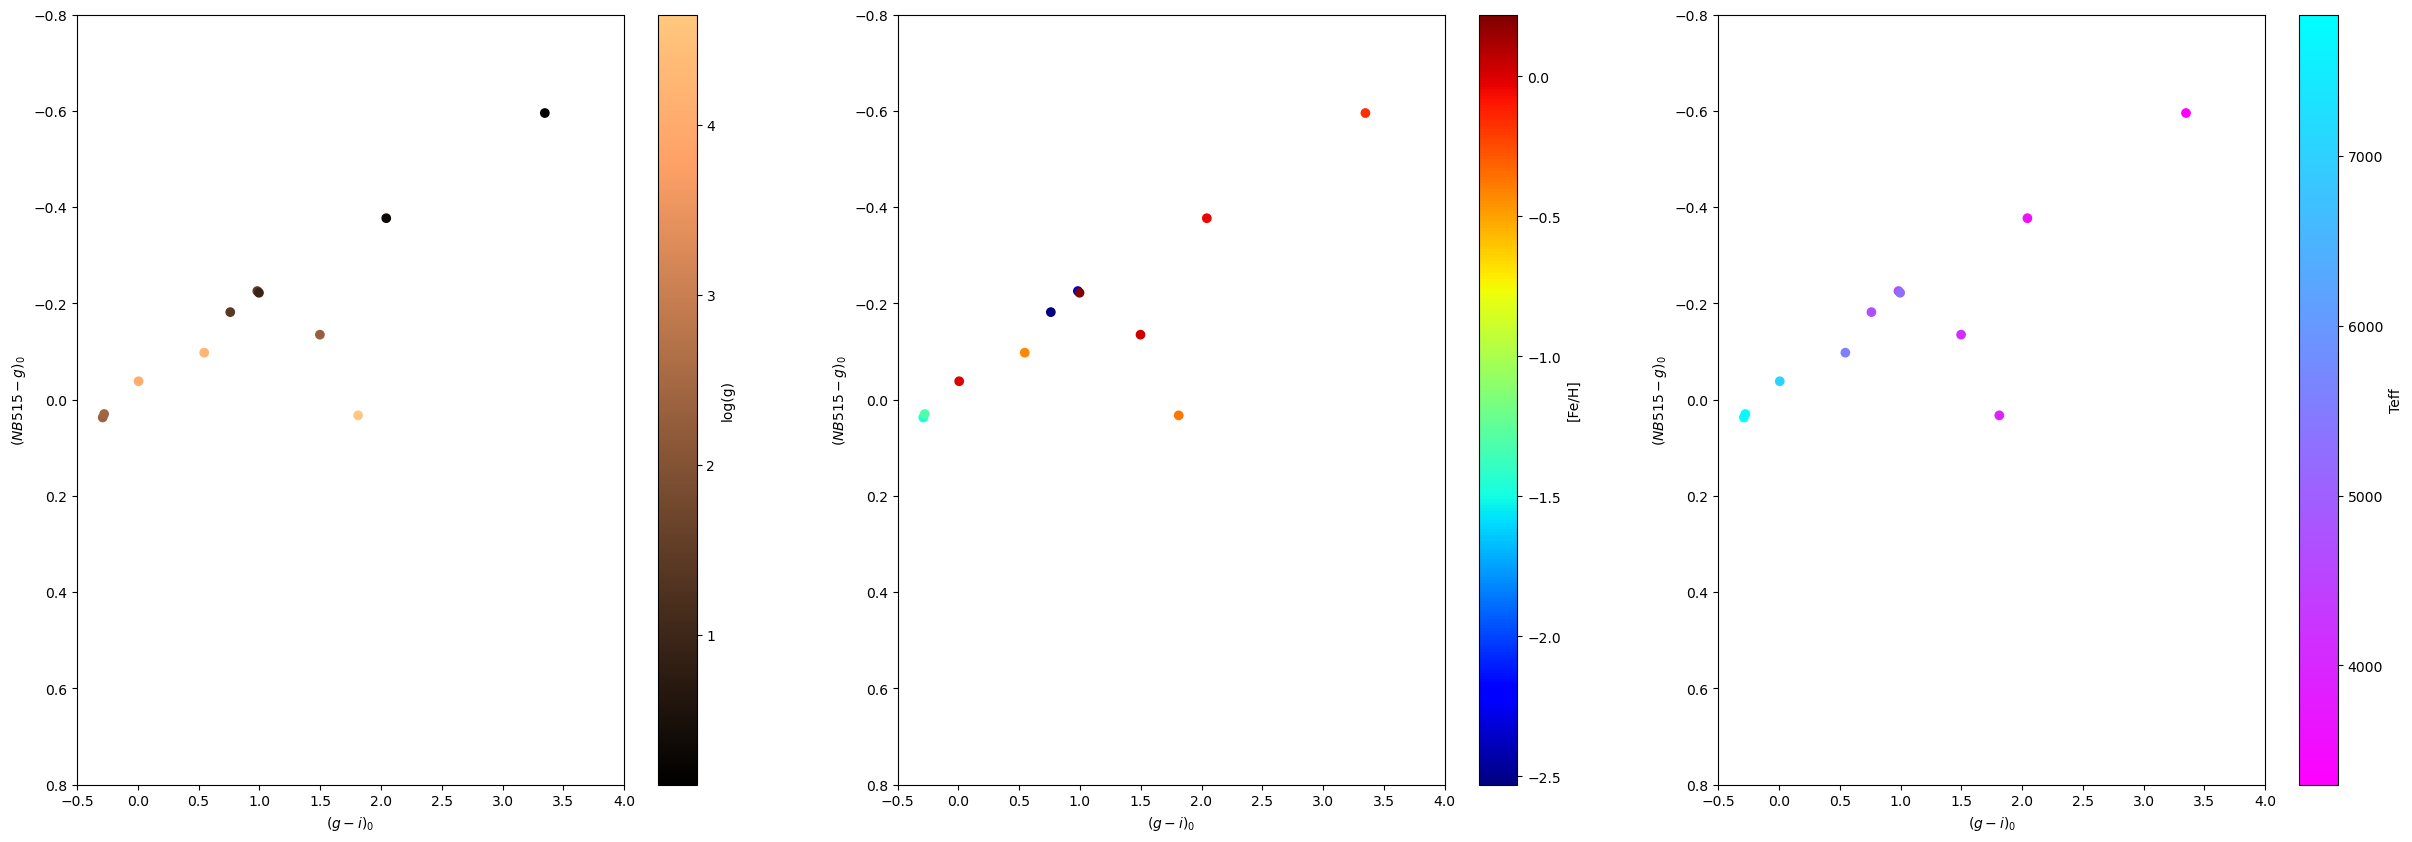

In [14]:
#plotting, color-coded by logg, metallicity, temp
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(30,10))
c1 = ax1.scatter(g_i_color, nb_g_color, c=loggs,cmap='copper')
ax1.set_xlim(-0.5, 4)
ax1.set_ylim(0.8,-0.8)
ax1.set_xlabel('$(g-i)_0$')
ax1.set_ylabel('$(NB515 - g)_0$')

c2 = ax2.scatter(g_i_color, nb_g_color, c=fehs,cmap='jet')
ax2.set_xlim(-0.5, 4)
ax2.set_ylim(0.8,-0.8)
ax2.set_xlabel('$(g-i)_0$')
ax2.set_ylabel('$(NB515 - g)_0$')

c3 = ax3.scatter(g_i_color, nb_g_color, c=teffs,cmap='cool_r')
ax3.set_xlim(-0.5, 4)
ax3.set_ylim(0.8,-0.8)
ax3.set_xlabel('$(g-i)_0$')
ax3.set_ylabel('$(NB515 - g)_0$')

fig.colorbar(c1, ax=ax1, orientation = 'vertical', label='log(g)')
fig.colorbar(c2, ax=ax2, orientation = 'vertical', label='[Fe/H]')
fig.colorbar(c3, ax=ax3, orientation = 'vertical', label='Teff')

## Next, lets look at /all/ of the stars with x-shooter spectra. We should look up the stars in Simbad that do NOT have stellar parameter information in the table from Vizier (we can look them up by their HNAME - they should all be on Simbad!) and we should also identify the stars with multiple entries. We should make a separate file with the stars without stellar parameter estimates, and add in parameter info as we find it (we should also note if they are 'weird' stars, like mira variables!). We can use the stars with multiple entries to better understand the precision and errors of our synthetic colors - it would be useful to know what kind of star each star with duplicate entries is, too!

### ( we can search for each of the stars on simbad, following this link http://simbad.u-strasbg.fr/simbad/ and putting the HNAME from the data file header into the 'basic search' bar)

In [15]:
from pathlib import Path
folder = Path(DATA_DIR)
files = []
for file_path in folder.glob('*fits'):
    files.append(file_path)

fehs = np.array([])
teffs = np.array([])
loggs = np.array([])
g_i_color = np.array([])
nb_g_color = np.array([])
names = []
cflag = []
ras = np.array([])
decs = np.array([])

custom_simbad = Simbad()
custom_simbad.add_votable_fields('sptype', 'otype', 'ids')

for i in range(len(files)):
    hdus = fits.open(files[i], memmap=False)
    name = hdus[0].header['HNAME']
    names.append(name)
    result = custom_simbad.query_object(name)
    otype = ''
    id = ''
    if result is not None:
        otype = result['OTYPE'][0].strip()
        id =  result['IDS'][0].strip()

    if name in Cstars:
        cflag.append(1)
    elif  otype=='AGB*' or otype=='post-AGB*':
        cflag.append(2)
    else:
        cflag.append(0)
    #get all the stellar param info
    logg = stellar_params[(stellar_params['HNAME'].str.contains(hdus[0].header['HNAME']))
            |(stellar_params['HNAME']==hdus[0].header['HNAME'])].logg.mean()
    loggs = np.append(loggs, logg)
    teff = stellar_params[(stellar_params['HNAME'].str.contains(hdus[0].header['HNAME']))
            |(stellar_params['HNAME']==hdus[0].header['HNAME'])].Teff.mean()
    teffs = np.append(teffs, teff)
    feh = stellar_params[(stellar_params['HNAME'].str.contains(hdus[0].header['HNAME']))
            |(stellar_params['HNAME']==hdus[0].header['HNAME'])]['__Fe_H_'].mean()
    fehs = np.append(fehs, feh)
    ra = stellar_params[(stellar_params['HNAME'].str.contains(hdus[0].header['HNAME']))
            |(stellar_params['HNAME']==hdus[0].header['HNAME'])]['_RA'].mean()
    ras = np.append(ras, ra)
    dec = stellar_params[(stellar_params['HNAME'].str.contains(hdus[0].header['HNAME']))
            |(stellar_params['HNAME']==hdus[0].header['HNAME'])]['_DE'].mean()
    decs = np.append(decs, dec)
    #synth_g = synthmagnoR(hdus[1], filt_g, dered=False)
    #synth_i = synthmagnoR(hdus[1], filt_i, dered=False)
    #synth_nb = synthmagnoR(hdus[1], filt_nb515, dered=False)

    g_i = synthcolor(hdus[1], filt_g, filt_i, dered=True)
    nb_g = synthcolor(hdus[1], filt_nb515, filt_g, dered=True)
    g_i_color = np.append(g_i_color, g_i)
    nb_g_color = np.append(nb_g_color, nb_g)
    hdus.close()
cflag = np.array(cflag)
synth_colors = pd.DataFrame()
synth_colors['name'] = names
synth_colors['gi'] = g_i_color
synth_colors['nbg'] = nb_g_color
synth_colors['logg'] = loggs
synth_colors['teff'] = teffs
synth_colors['feh'] = fehs
synth_colors['cflag'] = cflag
synth_colors['filename'] = files
synth_colors['ra'] = ras
synth_colors['dec'] = decs

first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!


/home/dkeyi/JHU/research/pfs/synth_colors/xshooter_synthmag.py:144: RuntimeWarning: divide by zero encountered in log10
  a1 = -2.5*np.log10((simps(s1*T1*lam1,lam1)/(stzp*simps(T1*lam1,lam1))))
/home/dkeyi/JHU/research/pfs/synth_colors/xshooter_synthmag.py:144: RuntimeWarning: divide by zero encountered in log10
  a1 = -2.5*np.log10((simps(s1*T1*lam1,lam1)/(stzp*simps(T1*lam1,lam1))))
/home/dkeyi/JHU/research/pfs/synth_colors/xshooter_synthmag.py:144: RuntimeWarning: divide by zero encountered in log10
  a1 = -2.5*np.log10((simps(s1*T1*lam1,lam1)/(stzp*simps(T1*lam1,lam1))))


first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!


/home/dkeyi/JHU/research/pfs/synth_colors/xshooter_synthmag.py:144: RuntimeWarning: divide by zero encountered in log10
  a1 = -2.5*np.log10((simps(s1*T1*lam1,lam1)/(stzp*simps(T1*lam1,lam1))))


first flux value is zero!
first flux value is zero!


/home/dkeyi/JHU/research/pfs/synth_colors/xshooter_synthmag.py:144: RuntimeWarning: divide by zero encountered in log10
  a1 = -2.5*np.log10((simps(s1*T1*lam1,lam1)/(stzp*simps(T1*lam1,lam1))))


first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!


first flux value is zero!
first flux value is zero!


/home/dkeyi/JHU/research/pfs/synth_colors/xshooter_synthmag.py:144: RuntimeWarning: divide by zero encountered in log10
  a1 = -2.5*np.log10((simps(s1*T1*lam1,lam1)/(stzp*simps(T1*lam1,lam1))))


first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!


/home/dkeyi/JHU/research/pfs/synth_colors/xshooter_synthmag.py:144: RuntimeWarning: divide by zero encountered in log10
  a1 = -2.5*np.log10((simps(s1*T1*lam1,lam1)/(stzp*simps(T1*lam1,lam1))))


first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!


/home/dkeyi/JHU/research/pfs/synth_colors/xshooter_synthmag.py:144: RuntimeWarning: divide by zero encountered in log10
  a1 = -2.5*np.log10((simps(s1*T1*lam1,lam1)/(stzp*simps(T1*lam1,lam1))))


first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!


first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!


/home/dkeyi/JHU/research/pfs/synth_colors/xshooter_synthmag.py:144: RuntimeWarning: divide by zero encountered in log10
  a1 = -2.5*np.log10((simps(s1*T1*lam1,lam1)/(stzp*simps(T1*lam1,lam1))))


first flux value is zero!
first flux value is zero!
first flux value is zero!


/home/dkeyi/JHU/research/pfs/synth_colors/xshooter_synthmag.py:144: RuntimeWarning: divide by zero encountered in log10
  a1 = -2.5*np.log10((simps(s1*T1*lam1,lam1)/(stzp*simps(T1*lam1,lam1))))


first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!


/home/dkeyi/JHU/research/pfs/synth_colors/xshooter_synthmag.py:144: RuntimeWarning: divide by zero encountered in log10
  a1 = -2.5*np.log10((simps(s1*T1*lam1,lam1)/(stzp*simps(T1*lam1,lam1))))


first flux value is zero!


first flux value is zero!
first flux value is zero!
first flux value is zero!


first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!


first flux value is zero!


first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!


/home/dkeyi/JHU/research/pfs/synth_colors/xshooter_synthmag.py:144: RuntimeWarning: divide by zero encountered in log10
  a1 = -2.5*np.log10((simps(s1*T1*lam1,lam1)/(stzp*simps(T1*lam1,lam1))))


first flux value is zero!
first flux value is zero!


/home/dkeyi/JHU/research/pfs/synth_colors/xshooter_synthmag.py:144: RuntimeWarning: divide by zero encountered in log10
  a1 = -2.5*np.log10((simps(s1*T1*lam1,lam1)/(stzp*simps(T1*lam1,lam1))))


first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!


/home/dkeyi/JHU/research/pfs/synth_colors/xshooter_synthmag.py:144: RuntimeWarning: divide by zero encountered in log10
  a1 = -2.5*np.log10((simps(s1*T1*lam1,lam1)/(stzp*simps(T1*lam1,lam1))))


first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!


/home/dkeyi/JHU/research/pfs/synth_colors/xshooter_synthmag.py:144: RuntimeWarning: divide by zero encountered in log10
  a1 = -2.5*np.log10((simps(s1*T1*lam1,lam1)/(stzp*simps(T1*lam1,lam1))))


first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!


/home/dkeyi/JHU/research/pfs/synth_colors/xshooter_synthmag.py:144: RuntimeWarning: divide by zero encountered in log10
  a1 = -2.5*np.log10((simps(s1*T1*lam1,lam1)/(stzp*simps(T1*lam1,lam1))))


first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!


/home/dkeyi/JHU/research/pfs/synth_colors/xshooter_synthmag.py:144: RuntimeWarning: divide by zero encountered in log10
  a1 = -2.5*np.log10((simps(s1*T1*lam1,lam1)/(stzp*simps(T1*lam1,lam1))))


first flux value is zero!
first flux value is zero!


/home/dkeyi/JHU/research/pfs/synth_colors/xshooter_synthmag.py:144: RuntimeWarning: divide by zero encountered in log10
  a1 = -2.5*np.log10((simps(s1*T1*lam1,lam1)/(stzp*simps(T1*lam1,lam1))))


first flux value is zero!
first flux value is zero!


/home/dkeyi/JHU/research/pfs/synth_colors/xshooter_synthmag.py:144: RuntimeWarning: divide by zero encountered in log10
  a1 = -2.5*np.log10((simps(s1*T1*lam1,lam1)/(stzp*simps(T1*lam1,lam1))))


first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!


/home/dkeyi/JHU/research/pfs/synth_colors/xshooter_synthmag.py:144: RuntimeWarning: divide by zero encountered in log10
  a1 = -2.5*np.log10((simps(s1*T1*lam1,lam1)/(stzp*simps(T1*lam1,lam1))))


first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!


/home/dkeyi/JHU/research/pfs/synth_colors/xshooter_synthmag.py:144: RuntimeWarning: divide by zero encountered in log10
  a1 = -2.5*np.log10((simps(s1*T1*lam1,lam1)/(stzp*simps(T1*lam1,lam1))))


first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!


/home/dkeyi/JHU/research/pfs/synth_colors/xshooter_synthmag.py:144: RuntimeWarning: divide by zero encountered in log10
  a1 = -2.5*np.log10((simps(s1*T1*lam1,lam1)/(stzp*simps(T1*lam1,lam1))))


first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!
first flux value is zero!


/tmp/ipykernel_1219/1431810100.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(g_i_color[cflag==2], nb_g_color[cflag==2],  marker='*', s=100, label='AGB', vmin=0, vmax=4.5)
/tmp/ipykernel_1219/1431810100.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(g_i_color[cflag==1], nb_g_color[cflag==1],  marker='^', s=100, label='Carbon Stars', vmin=0, vmax=4.5)


Text(0, 0.5, '$(NB515-g)_0$')

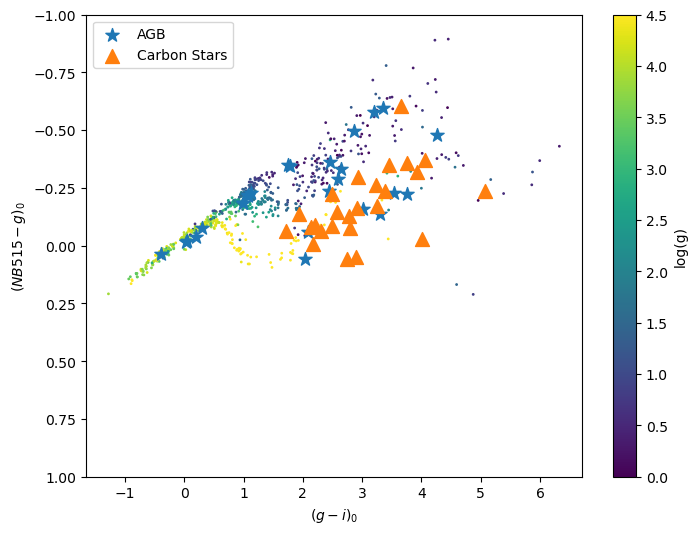

In [16]:
mastar = pd.read_csv('../M31_hsc/MaStar_synthmag_dered_spec_sch.csv')
plt.figure(figsize=[8,6])
# plt.scatter(mastar['gi_0'],mastar['nbg_0'],c=mastar['logg_med'],cmap='rainbow',s=1, vmin = 0, vmax=5, alpha=0.05)
cb = plt.scatter(g_i_color,nb_g_color,s=1, c=loggs, vmin=0, vmax=4.5)
plt.scatter(g_i_color[cflag==2], nb_g_color[cflag==2],  marker='*', s=100, label='AGB', vmin=0, vmax=4.5)
plt.scatter(g_i_color[cflag==1], nb_g_color[cflag==1],  marker='^', s=100, label='Carbon Stars', vmin=0, vmax=4.5)
plt.colorbar(cb, label='log(g)')
# plt.gca().invert_yaxis()
plt.ylim(1, -1)
plt.legend(loc='best')
plt.xlabel(r'$(g-i)_0$')
plt.ylabel(r'$(NB515-g)_0$')

Text(0, 0.5, '$(NB515-g)_0$')

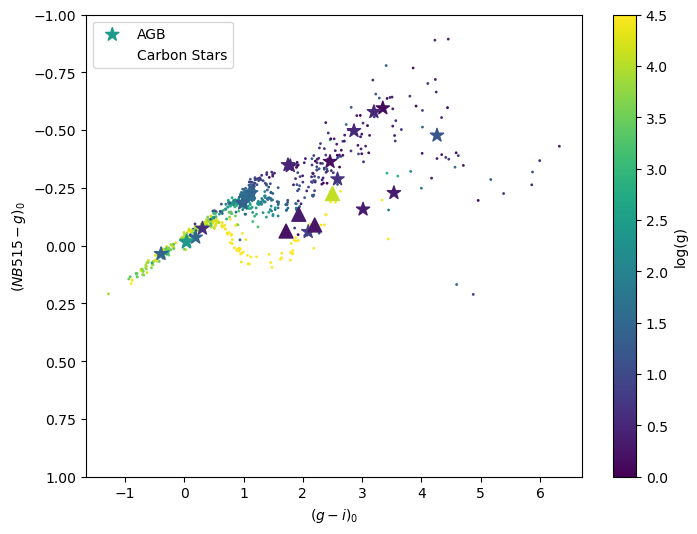

In [17]:
mastar = pd.read_csv('../M31_hsc/MaStar_synthmag_dered_spec_sch.csv')
plt.figure(figsize=[8,6])
# plt.scatter(mastar['gi_0'],mastar['nbg_0'],c=mastar['logg_med'],cmap='rainbow',s=1, vmin = 0, vmax=5, alpha=0.05)
cb = plt.scatter(g_i_color,nb_g_color,s=1, c=loggs, vmin=0, vmax=4.5)
plt.scatter(g_i_color[cflag==2], nb_g_color[cflag==2],  marker='*', s=100, label='AGB', c=loggs[cflag==2],vmin=0, vmax=4.5)
plt.scatter(g_i_color[cflag==1], nb_g_color[cflag==1],  marker='^', s=100, label='Carbon Stars', c=loggs[cflag==1],vmin=0, vmax=4.5)
plt.colorbar(cb, label='log(g)')
# plt.gca().invert_yaxis()
plt.ylim(1, -1)
plt.legend(loc='best')
plt.xlabel(r'$(g-i)_0$')
plt.ylabel(r'$(NB515-g)_0$')

In [18]:
synth_colors[synth_colors['cflag']==1][['name', 'logg', 'teff', 'feh']]

,name,logg,teff,feh
8,[ABC89] Cir18,3.67,3142.0,0.82
16,[ABC89] Cir18,3.67,3142.0,0.82
18,SHV 0520505-705019,NaN,<NA>,NaN
25,SHV 0520427-693637,NaN,<NA>,NaN
57,SHV 0502469-692418,NaN,<NA>,NaN
85,ISO-MCMS J005700.7-730751,NaN,<NA>,NaN
122,SHV 0504353-712622,NaN,<NA>,NaN
146,SHV 0536139-701604,NaN,<NA>,NaN
158,ISO-MCMS J005644.8-731436,NaN,<NA>,NaN
185,ISO-MCMS J005307.8-730747,NaN,<NA>,NaN


In [19]:
cstar_files = []
for i in range(len(files)):
    hdus = fits.open(files[i], memmap=False)
    name = hdus[0].header['HNAME']
    if name in Cstars:
        cstar_files.append(files[i])
    hdus.close()

In [20]:
len(cstar_files)

33

In [21]:
def fix_neg_nan_flux(arr):
    #most code taken from https://stackoverflow.com/questions/30488961/fill-zero-values-of-1d-numpy-array-with-last-non-zero-values
    #which doesn't handle first value being zero, here I just force first value to be greater
    #than zero
    if arr[0] <= 0:
        print('first flux value is zero!')
        arr[0] = np.nanmean(arr[0:500]) #if first value in flux is zero, just replace w mean of first 500 values

    arr[(np.isnan(arr)==True)] = 0 #where flux is negative or nan, replace with zero
    arr[(arr<0)] = 0 #breaking into two to stop warnings complaining ab nans in less than
    prev = np.arange(len(arr)) #make array of indexes
    prev[arr == 0] = 0 #where array is zero, set index to zero
    prev = np.maximum.accumulate(prev) #get the maximum of the index array up to each value in array, 
    #i.e. for no zeros, this is just gonna give you back the indexes. for zeros, this 
    #will give you the largest previous index, so last index where value wasnt zero
    return arr[prev] #re-index with this new array

In [22]:
with open('fHSC-i.txt', 'r') as file:
    Lines = file.readlines()
i_w = []
i_bp = []
for i in Lines:
    i_w.append(float(i[0:12]))
    i_bp.append(float(i[13:23]))
    
with open('fHSC-g.txt', 'r') as file:
    Lines = file.readlines()
g_w = []
g_bp = []
for i in Lines:
    g_w.append(float(i[0:12]))
    g_bp.append(float(i[13:23]))
    
with open('fHSC-NB515.txt', 'r') as file:
    Lines = file.readlines()
nb_w = []
nb_bp = []
for i in Lines:
    nb_w.append(float(i[0:12]))
    nb_bp.append(float(i[13:23]))

first flux value is zero!


(0.0, 1.0)

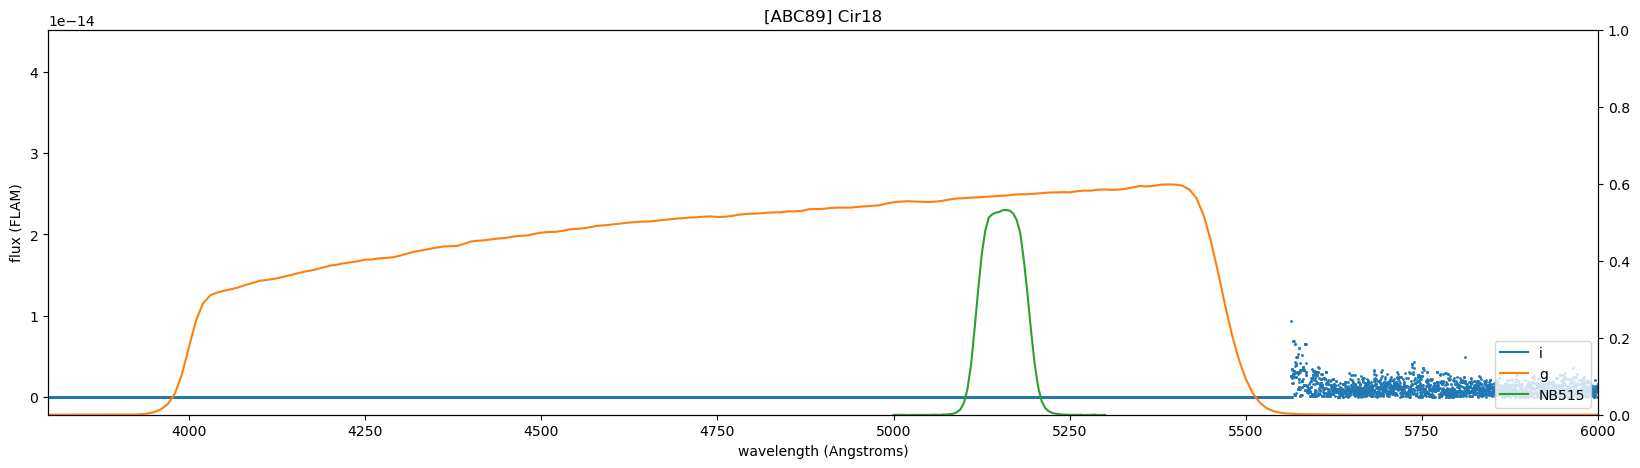

In [23]:
hdus = fits.open(cstar_files[0], memmap=False)
name = hdus[0].header['HNAME']
fig, ax = plt.subplots(figsize=(20, 5))
wl_raw = hdus[1].data['WAVE']*10
wl = wl_raw[(wl_raw>3800) & (wl_raw < 9000)]
flux = fix_neg_nan_flux(hdus[1].data['FLUX'])[(wl_raw>3800) & (wl_raw < 9000)]
plt.scatter(wl, flux, s=1)
plt.xlim(3800, 6000)
hdus.close()
plt.ylabel("flux (FLAM)")
plt.xlabel("wavelength (Angstroms)")
plt.title(name)
ax1 = ax.twinx()
plt.plot(i_w, i_bp, label='i')
plt.plot(g_w, g_bp, label='g')
plt.plot(nb_w, nb_bp, label='NB515')
plt.legend(loc=4)
plt.ylim(0, 1)

first flux value is zero!


(0.0, 1.0)

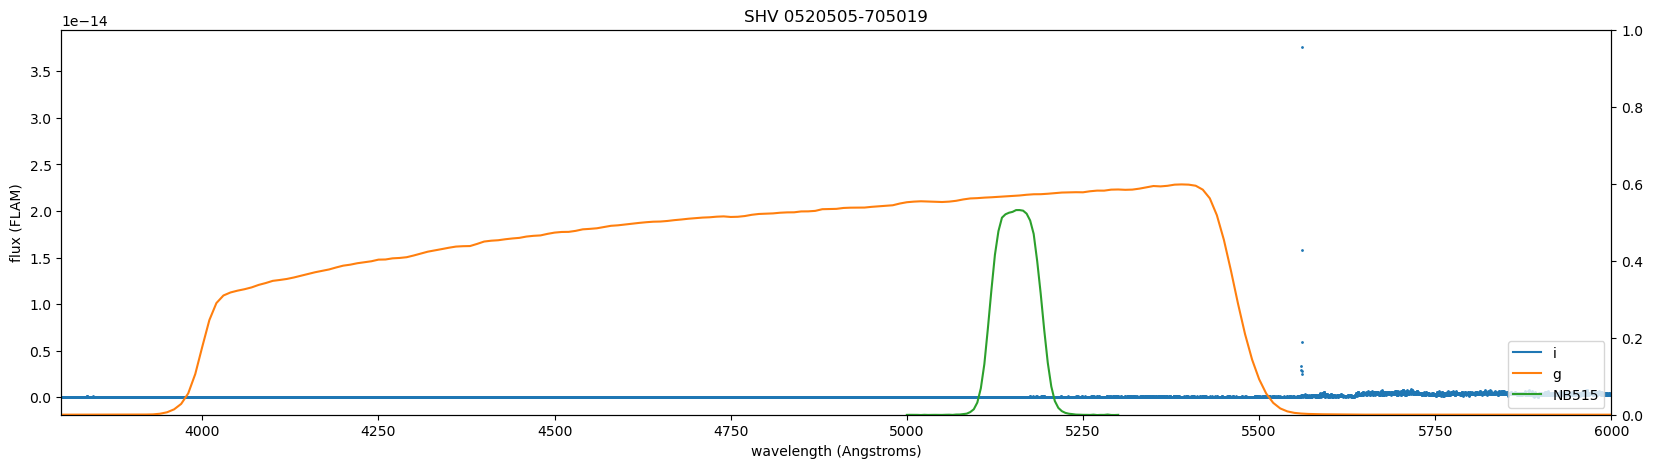

In [24]:
hdus = fits.open(cstar_files[2], memmap=False)
name = hdus[0].header['HNAME']
fig, ax = plt.subplots(figsize=(20, 5))
wl_raw = hdus[1].data['WAVE']*10
wl = wl_raw[(wl_raw>3800) & (wl_raw < 9000)]
flux = fix_neg_nan_flux(hdus[1].data['FLUX'])[(wl_raw>3800) & (wl_raw < 9000)]
plt.scatter(wl, flux, s=1)
plt.xlim(3800, 6000)
hdus.close()
plt.ylabel("flux (FLAM)")
plt.xlabel("wavelength (Angstroms)")
plt.title(name)
ax1 = ax.twinx()
plt.plot(i_w, i_bp, label='i')
plt.plot(g_w, g_bp, label='g')
plt.plot(nb_w, nb_bp, label='NB515')
plt.legend(loc=4)
plt.ylim(0, 1)


(0.0, 1.0)

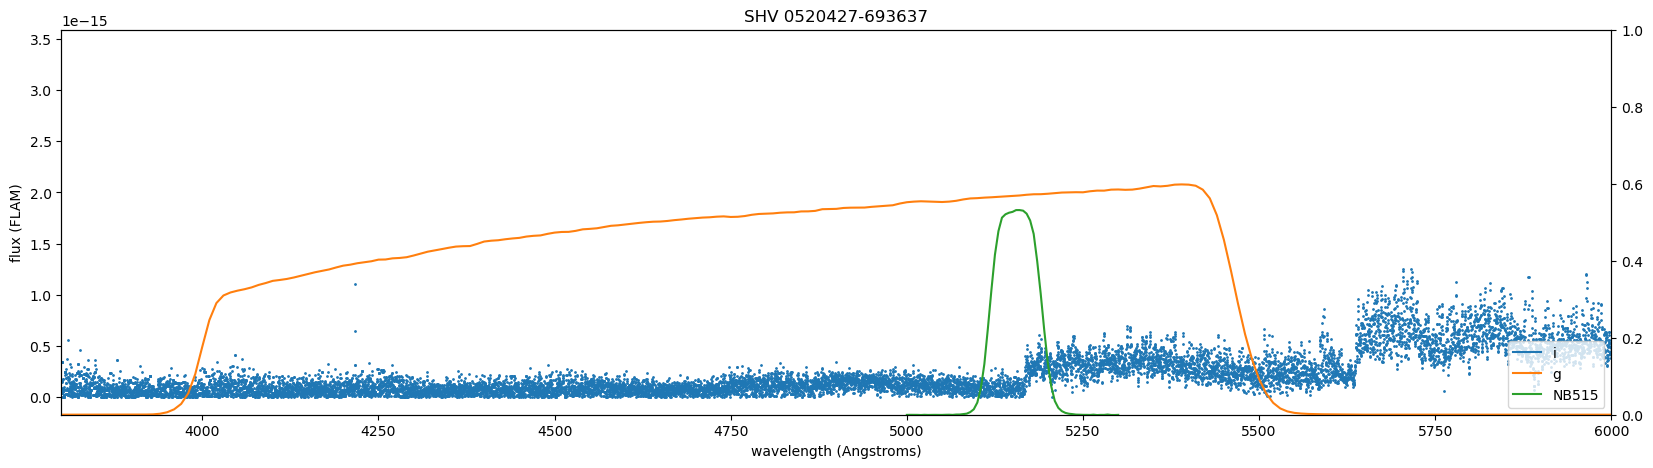

In [25]:
hdus = fits.open(cstar_files[3], memmap=False)
name = hdus[0].header['HNAME']
fig, ax = plt.subplots(figsize=(20, 5))
wl_raw = hdus[1].data['WAVE']*10
wl = wl_raw[(wl_raw>3800) & (wl_raw < 9000)]
flux = fix_neg_nan_flux(hdus[1].data['FLUX'])[(wl_raw>3800) & (wl_raw < 9000)]
plt.scatter(wl, flux, s=1)
plt.xlim(3800, 6000)
hdus.close()
plt.ylabel("flux (FLAM)")
plt.xlabel("wavelength (Angstroms)")
plt.title(name)
ax1 = ax.twinx()
plt.plot(i_w, i_bp, label='i')
plt.plot(g_w, g_bp, label='g')
plt.plot(nb_w, nb_bp, label='NB515')
plt.legend(loc=4)
plt.ylim(0, 1)

first flux value is zero!
SHV 0502469-692418


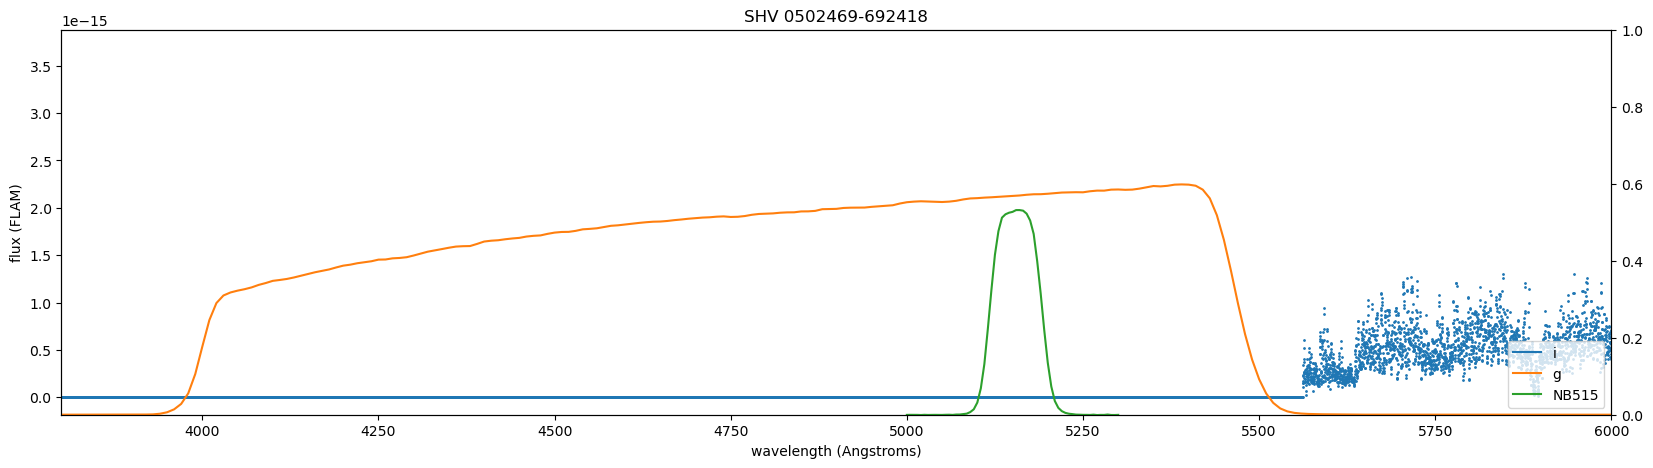

In [26]:
hdus = fits.open(cstar_files[4], memmap=False)
name = hdus[0].header['HNAME']
fig, ax = plt.subplots(figsize=(20, 5))
wl_raw = hdus[1].data['WAVE']*10
wl = wl_raw[(wl_raw>3800) & (wl_raw < 9000)]
flux = fix_neg_nan_flux(hdus[1].data['FLUX'])[(wl_raw>3800) & (wl_raw < 9000)]
plt.scatter(wl, flux, s=1)
plt.xlim(3800, 6000)
hdus.close()
plt.ylabel("flux (FLAM)")
plt.xlabel("wavelength (Angstroms)")
plt.title(name)
ax1 = ax.twinx()
plt.plot(i_w, i_bp, label='i')
plt.plot(g_w, g_bp, label='g')
plt.plot(nb_w, nb_bp, label='NB515')
plt.legend(loc=4)
plt.ylim(0, 1)
print(name)

first flux value is zero!


(0.0, 1.0)

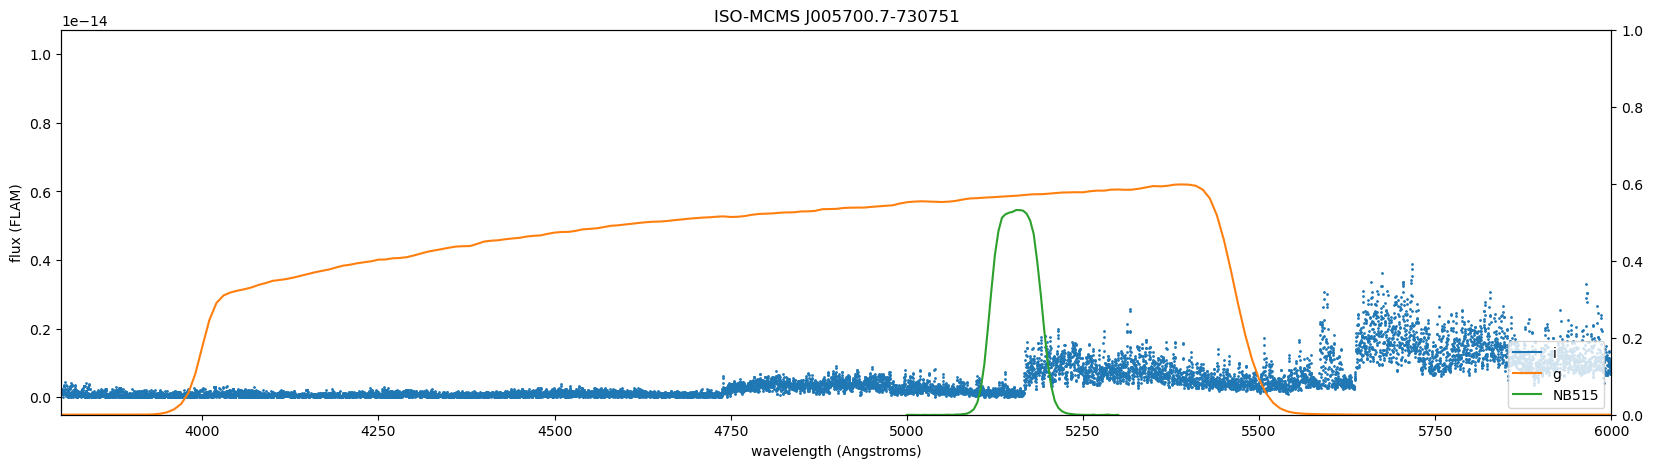

In [27]:
hdus = fits.open(cstar_files[5], memmap=False)
name = hdus[0].header['HNAME']
fig, ax = plt.subplots(figsize=(20, 5))
wl_raw = hdus[1].data['WAVE']*10
wl = wl_raw[(wl_raw>3800) & (wl_raw < 9000)]
flux = fix_neg_nan_flux(hdus[1].data['FLUX'])[(wl_raw>3800) & (wl_raw < 9000)]
plt.scatter(wl, flux, s=1)
plt.xlim(3800, 6000)
hdus.close()
plt.ylabel("flux (FLAM)")
plt.xlabel("wavelength (Angstroms)")
plt.title(name)
ax1 = ax.twinx()
plt.plot(i_w, i_bp, label='i')
plt.plot(g_w, g_bp, label='g')
plt.plot(nb_w, nb_bp, label='NB515')
plt.legend(loc=4)
plt.ylim(0, 1)

(0.0, 1.0)

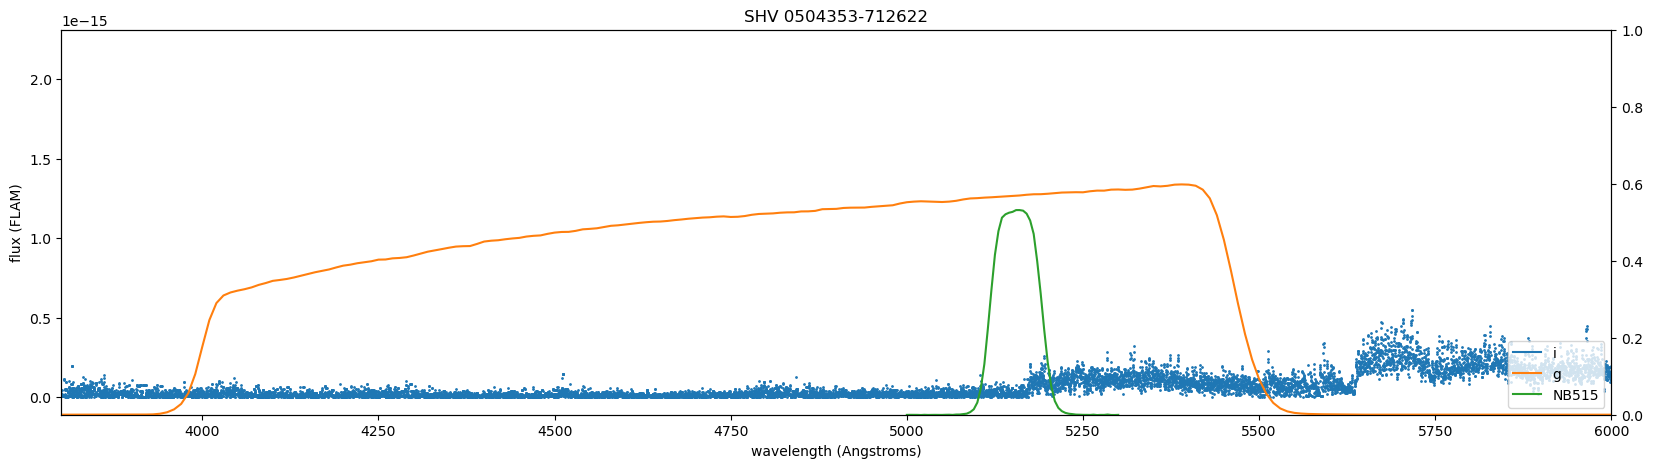

In [28]:
hdus = fits.open(cstar_files[6], memmap=False)
name = hdus[0].header['HNAME']
fig, ax = plt.subplots(figsize=(20, 5))
wl_raw = hdus[1].data['WAVE']*10
wl = wl_raw[(wl_raw>3800) & (wl_raw < 9000)]
flux = fix_neg_nan_flux(hdus[1].data['FLUX'])[(wl_raw>3800) & (wl_raw < 9000)]
plt.scatter(wl, flux, s=1)
plt.xlim(3800, 6000)
hdus.close()
plt.ylabel("flux (FLAM)")
plt.xlabel("wavelength (Angstroms)")
plt.title(name)
ax1 = ax.twinx()
plt.plot(i_w, i_bp, label='i')
plt.plot(g_w, g_bp, label='g')
plt.plot(nb_w, nb_bp, label='NB515')
plt.legend(loc=4)
plt.ylim(0, 1)

first flux value is zero!
SHV 0536139-701604


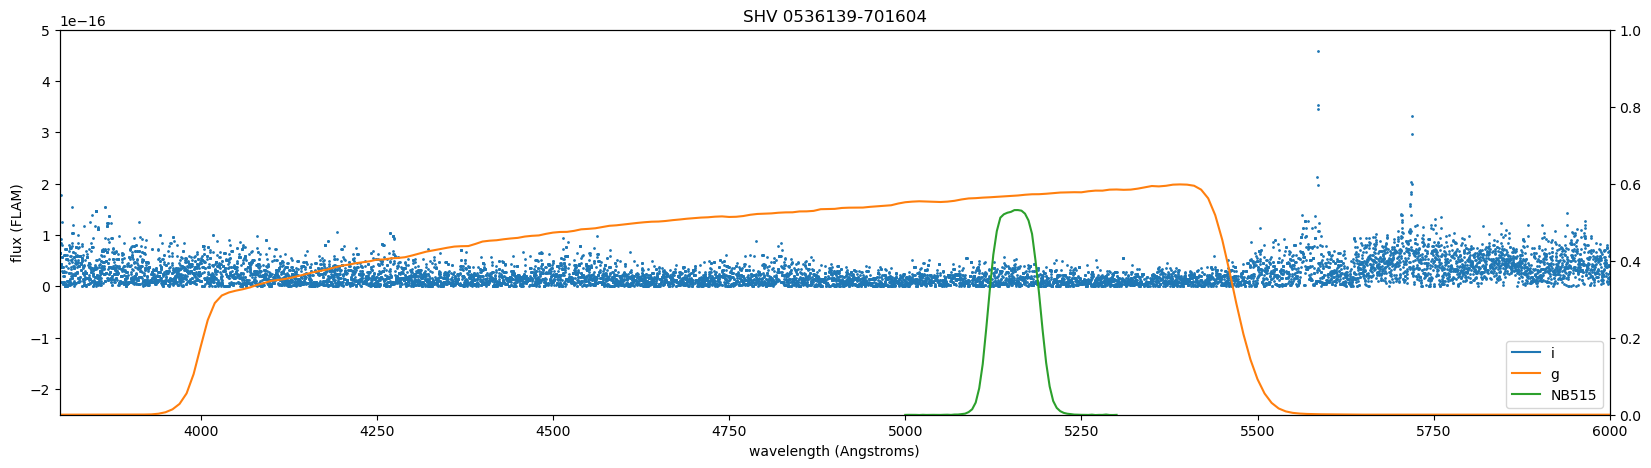

In [29]:
hdus = fits.open(cstar_files[7], memmap=False)
name = hdus[0].header['HNAME']
fig, ax = plt.subplots(figsize=(20, 5))
wl_raw = hdus[1].data['WAVE']*10
wl = wl_raw[(wl_raw>3800) & (wl_raw < 9000)]
flux = fix_neg_nan_flux(hdus[1].data['FLUX'])[(wl_raw>3800) & (wl_raw < 9000)]
plt.scatter(wl, flux, s=1)
plt.xlim(3800, 6000)
plt.ylim(-0.25e-15, 0.5e-15)
hdus.close()
plt.ylabel("flux (FLAM)")
plt.xlabel("wavelength (Angstroms)")
plt.title(name)
ax1 = ax.twinx()
plt.plot(i_w, i_bp, label='i')
plt.plot(g_w, g_bp, label='g')
plt.plot(nb_w, nb_bp, label='NB515')
plt.legend(loc=4)
plt.ylim(0, 1)
print(name)

first flux value is zero!
SHV 0536139-701604


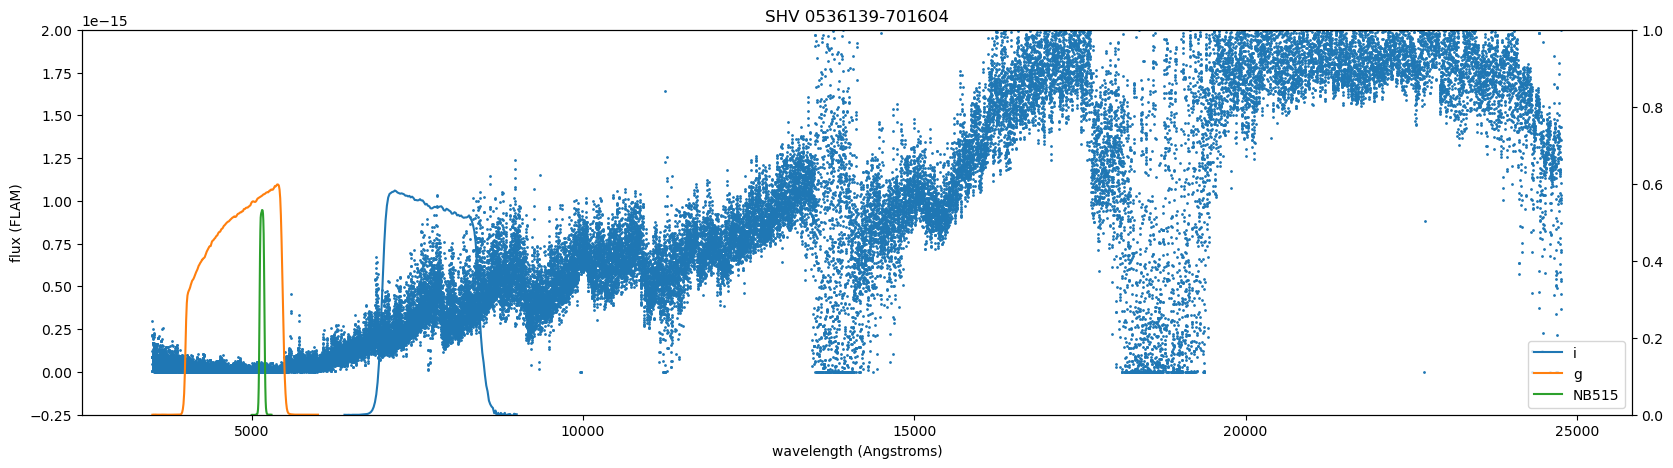

In [30]:
hdus = fits.open(cstar_files[7], memmap=False)
name = hdus[0].header['HNAME']
fig, ax = plt.subplots(figsize=(20, 5))
wl_raw = hdus[1].data['WAVE']*10
wl = wl_raw[(wl_raw>3800) & (wl_raw < 9000)]
flux = fix_neg_nan_flux(hdus[1].data['FLUX'])
plt.scatter(wl_raw, flux, s=1)
# plt.xlim(3800, 6000)
plt.ylim(-0.25e-15, 2e-15)
hdus.close()
plt.ylabel("flux (FLAM)")
plt.xlabel("wavelength (Angstroms)")
plt.title(name)
ax1 = ax.twinx()
plt.plot(i_w, i_bp, label='i')
plt.plot(g_w, g_bp, label='g')
plt.plot(nb_w, nb_bp, label='NB515')
plt.legend(loc=4)
plt.ylim(0, 1)
print(name)

In [31]:
synth_colors[synth_colors['name']=='CL* NGC 419 LE 35']

,name,gi,nbg,logg,teff,feh,cflag,filename,ra,dec
332,CL* NGC 419 LE 35,2.49902,-0.225757,4.08,6222.0,-0.26,1,XSL_DR3_release/XSL_DR3_release/xsl_spectrum_X...,17.07287,-72.88369


CL* NGC 419 LE 35


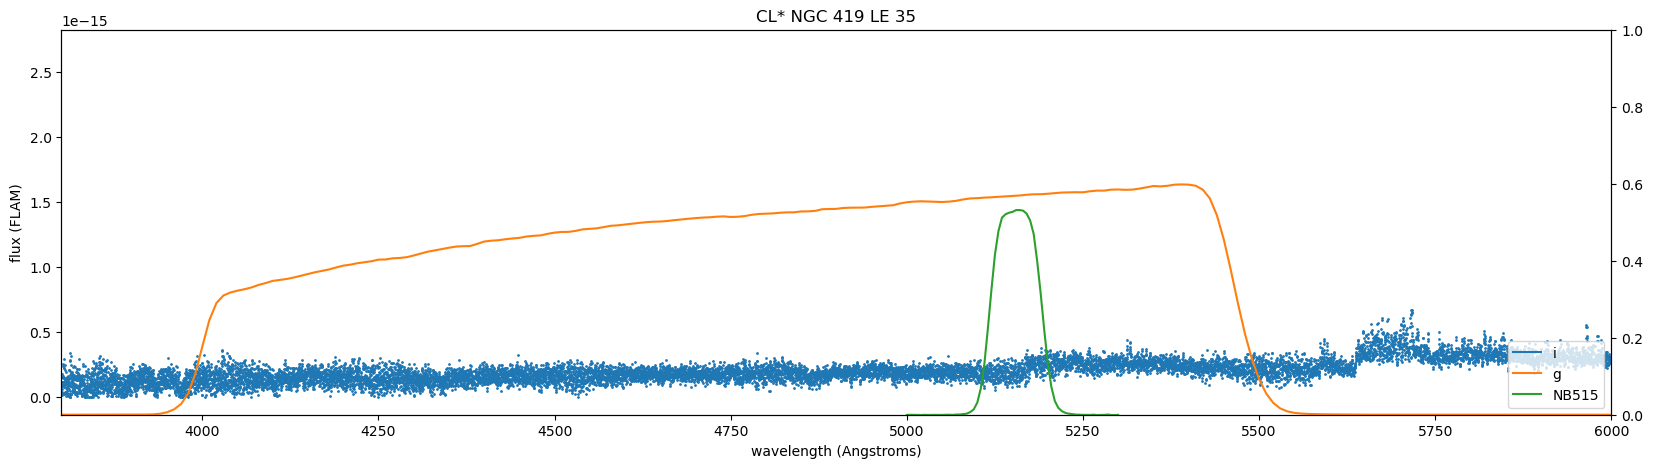

In [32]:
hdus = fits.open(synth_colors[synth_colors['name']=='CL* NGC 419 LE 35']['filename'].iloc[0], memmap=False)
name = hdus[0].header['HNAME']
fig, ax = plt.subplots(figsize=(20, 5))
wl_raw = hdus[1].data['WAVE']*10
wl = wl_raw[(wl_raw>3800) & (wl_raw < 9000)]
flux = fix_neg_nan_flux(hdus[1].data['FLUX'])[(wl_raw>3800) & (wl_raw < 9000)]
plt.scatter(wl, flux, s=1)
plt.xlim(3800, 6000)
hdus.close()
plt.ylabel("flux (FLAM)")
plt.xlabel("wavelength (Angstroms)")
plt.title(name)
ax1 = ax.twinx()
plt.plot(i_w, i_bp, label='i')
plt.plot(g_w, g_bp, label='g')
plt.plot(nb_w, nb_bp, label='NB515')
plt.legend(loc=4)
plt.ylim(0, 1)
print(name)

In [33]:
synth_colors[
    synth_colors['nbg'].isnull() | 
    synth_colors['nbg'].isna() |
    np.isinf(synth_colors['nbg'])
]

,name,gi,nbg,logg,teff,feh,cflag,filename,ra,dec
8,[ABC89] Cir18,12.346219,inf,3.670,3142.0,0.820,1,XSL_DR3_release/XSL_DR3_release/xsl_spectrum_X...,208.86000,-59.37331
9,OGLEII DIA BUL-SC13 0324,12.403526,inf,0.600,3154.0,-0.260,0,XSL_DR3_release/XSL_DR3_release/xsl_spectrum_X...,274.19800,-24.34233
10,LHS 2065,13.191032,inf,2.845,3272.0,-0.635,0,XSL_DR3_release/XSL_DR3_release/xsl_spectrum_X...,133.40067,-3.49228
16,[ABC89] Cir18,12.015555,inf,3.670,3142.0,0.820,1,XSL_DR3_release/XSL_DR3_release/xsl_spectrum_X...,208.86000,-59.37331
23,GJ 752B,10.164165,inf,NaN,<NA>,NaN,0,XSL_DR3_release/XSL_DR3_release/xsl_spectrum_X...,289.24004,5.15044
57,SHV 0502469-692418,12.664765,inf,NaN,<NA>,NaN,1,XSL_DR3_release/XSL_DR3_release/xsl_spectrum_X...,75.62037,-69.33606
109,HV 12149,12.024927,inf,0.630,2921.0,0.480,2,XSL_DR3_release/XSL_DR3_release/xsl_spectrum_X...,14.70904,-72.30989
155,OGLEII DIA BUL-SC22 1319,11.815612,inf,0.340,3097.0,0.000,0,XSL_DR3_release/XSL_DR3_release/xsl_spectrum_X...,269.29246,-31.03797
214,SHV 0528537-695119,11.178248,inf,4.390,16629.0,-0.200,1,XSL_DR3_release/XSL_DR3_release/xsl_spectrum_X...,82.11554,-69.81717
245,OGLEII DIA BUL-SC41 3443,15.402510,inf,NaN,<NA>,NaN,0,XSL_DR3_release/XSL_DR3_release/xsl_spectrum_X...,NaN,NaN


In [34]:
synth_colors = synth_colors[synth_colors['nbg'] < 999]

In [35]:
synth_colors.to_csv('xshooter_synthcolor.csv', index=False)

In [36]:
sdss = pd.read_csv('xshooter_synthcolor_sdss.csv')
ps1 = pd.read_csv('xshooter_synthcolor_PS1.csv')
skymapper = pd.read_csv('xshooter_synthcolor_skymapper.csv')

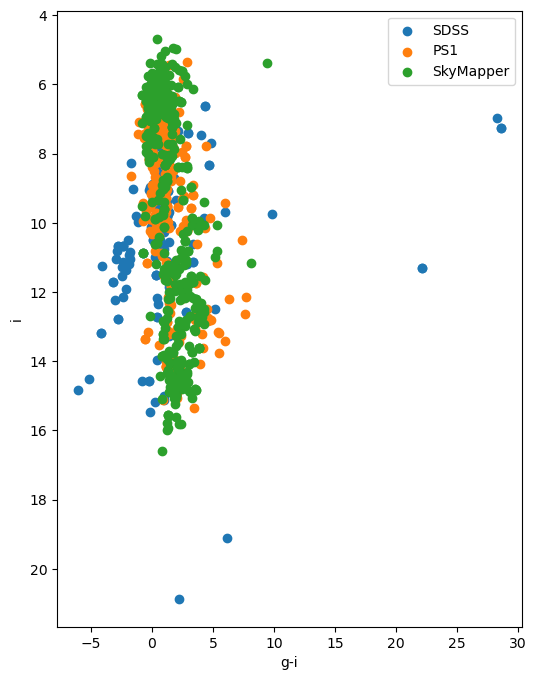

In [37]:
fig, ax = plt.subplots(figsize=(6, 8))
plt.scatter(sdss['gmag']-sdss['imag'], sdss['imag'], label='SDSS')
plt.scatter(ps1['gmag']-ps1['imag'], ps1['imag'], label='PS1')
plt.scatter(skymapper['gPSF']-skymapper['iPSF'], skymapper['iPSF'], label='SkyMapper')
plt.xlabel('g-i')
plt.ylabel('i')
plt.legend(loc='best')
plt.gca().invert_yaxis()

Text(0, 0.5, 'SDSkyMapper g-i')

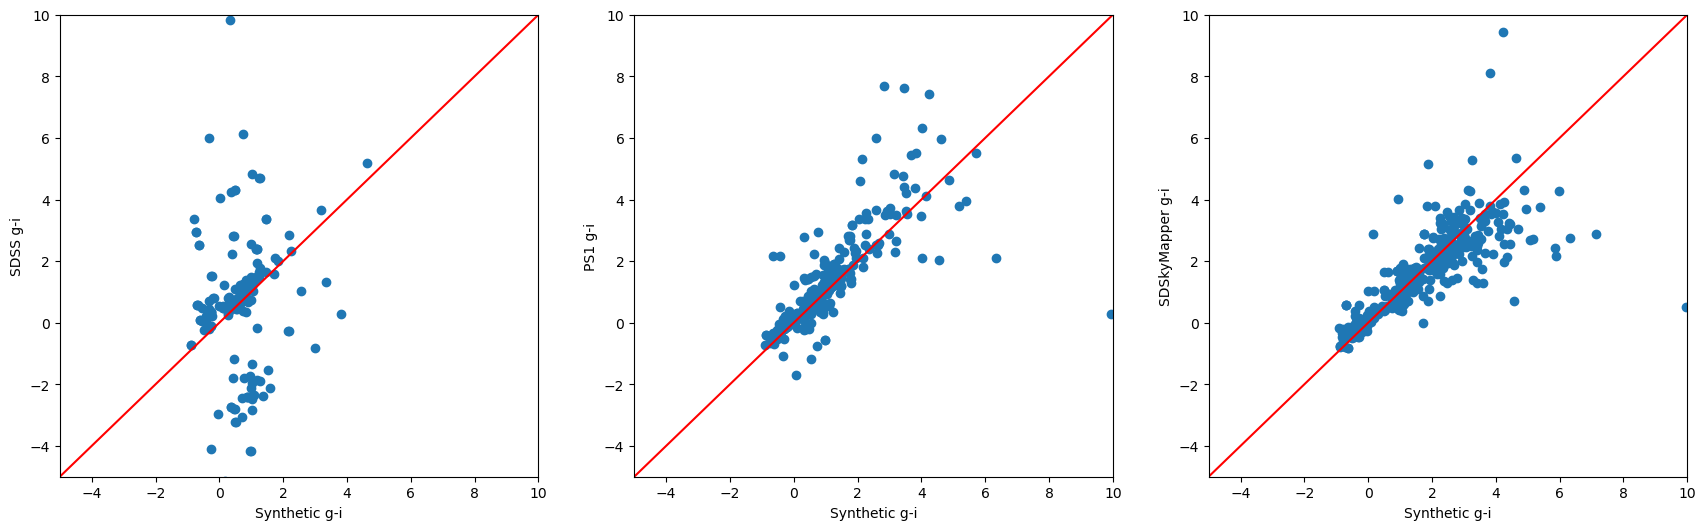

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(21,6))
ax1.scatter(sdss['gi'],sdss['gmag']-sdss['imag'])
ax1.set_xlim(-5, 10)
ax1.set_ylim(-5, 10)
ax1.plot(np.arange(-5, 11, 1), np.arange(-5, 11, 1), c='r')
ax1.set_xlabel('Synthetic g-i')
ax1.set_ylabel('SDSS g-i')
ax2.scatter(ps1['gi'], ps1['gmag']-ps1['imag'])
ax2.set_xlim(-5, 10)
ax2.set_ylim(-5, 10)
ax2.plot(np.arange(-5, 11, 1), np.arange(-5, 11, 1), c='r')
ax2.set_xlabel('Synthetic g-i')
ax2.set_ylabel('PS1 g-i')
ax3.scatter(skymapper['gi'], skymapper['gPSF']-skymapper['iPSF'])
ax3.set_xlim(-5, 10)
ax3.set_ylim(-5, 10)
ax3.plot(np.arange(-5, 11, 1), np.arange(-5, 11, 1), c='r')
ax3.set_xlabel('Synthetic g-i')
ax3.set_ylabel('SDSkyMapper g-i')

In [39]:
sources = ['SDSS', 'PS1', 'SkyMapper']
obs_g = []
obs_i = []
obs_source = []
repeat = 0
for i in range(len(synth_colors)):
    name = synth_colors['name'].iloc[i]
    sdss_star = sdss[sdss['name']==name]
    ps1_star = ps1[ps1['name']==name]
    skymapper_star = skymapper[skymapper['name']==name]
    synth_gi =  synth_colors['gi'].iloc[i]

    gmags = np.array([np.nan if len(sdss_star)<1 else sdss_star['gmag'].iloc[0], np.nan if len(ps1_star)<1 else ps1_star['gmag'].iloc[0], np.nan if len(skymapper_star)<1 else skymapper_star['gPSF'].iloc[0]])
    gmags_err = np.array([np.nan if len(sdss_star)<1 else sdss_star['e_gmag'].iloc[0], np.nan if len(ps1_star)<1 else ps1_star['e_gmag'].iloc[0], np.nan if len(skymapper_star)<1 else skymapper_star['e_gPSF'].iloc[0]])
    imags = np.array([np.nan if len(sdss_star)<1 else sdss_star['imag'].iloc[0], np.nan if len(ps1_star)<1 else ps1_star['imag'].iloc[0], np.nan if len(skymapper_star)<1 else skymapper_star['iPSF'].iloc[0]])
    imags_err = np.array([np.nan if len(sdss_star)<1 else sdss_star['e_imag'].iloc[0], np.nan if len(ps1_star)<1 else ps1_star['e_imag'].iloc[0], np.nan if len(skymapper_star)<1 else skymapper_star['e_iPSF'].iloc[0]])

    if np.isnan(imags).sum()<2:
        repeat += 1
    if np.isnan(imags).sum() == 3:
        gmag = np.nan
        imag = np.nan
        source = np.nan
    else:
        diff = np.array(abs((gmags-imags)-synth_gi))
        diff = np.nan_to_num(diff, nan = 999)
        ind = np.argmin(diff)
        gmag = gmags[ind]
        imag = imags[ind]
        source = sources[ind]

        if diff[ind] > 3 * np.sqrt(gmags_err[ind] **2 + imags_err[ind] ** 2) or diff[ind] > 1:
            gmag = np.nan
            imag = np.nan
            source = np.nan

    obs_g.append(gmag)
    obs_i.append(imag)
    obs_source.append(source)

synth_colors['obs_g'] = obs_g
synth_colors['obs_i'] = obs_i
synth_colors['obs_source'] = obs_source
    

In [40]:
synth_colors

,name,gi,nbg,logg,teff,feh,cflag,filename,ra,dec,obs_g,obs_i,obs_source
0,AL Mon,3.245570,-0.587056,0.640000,3201.0,-0.440,0,XSL_DR3_release/XSL_DR3_release/xsl_spectrum_X...,108.217370,-5.34644,NaN,NaN,NaN
1,OGLEII DIA BUL-SC19 2302,0.939979,-0.025384,1.520000,3360.0,-0.190,0,XSL_DR3_release/XSL_DR3_release/xsl_spectrum_X...,271.896710,-27.25950,NaN,NaN,NaN
2,[M2002] SMC 46662,2.184637,-0.390402,0.800000,3777.0,-0.710,0,XSL_DR3_release/XSL_DR3_release/xsl_spectrum_X...,14.895870,-72.06844,NaN,NaN,NaN
3,HD 4906,0.713973,-0.115675,2.770000,4832.5,-0.365,0,XSL_DR3_release/XSL_DR3_release/xsl_spectrum_X...,57.118875,-1.03117,NaN,NaN,NaN
4,HD 88737,0.347324,-0.102432,3.920000,6072.0,0.150,0,XSL_DR3_release/XSL_DR3_release/xsl_spectrum_X...,153.623960,21.16806,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,HD 205734,-0.261139,0.008682,3.673333,7946.0,-0.010,0,XSL_DR3_release/XSL_DR3_release/xsl_spectrum_X...,324.308710,5.85142,7.9426,8.0853,SkyMapper
826,HD 193326,0.781232,-0.171349,2.800000,5127.0,-0.260,0,XSL_DR3_release/XSL_DR3_release/xsl_spectrum_X...,304.914920,1.99344,8.2720,7.4780,PS1
827,HD 13043,0.503830,-0.078497,4.060000,5755.0,-0.030,0,XSL_DR3_release/XSL_DR3_release/xsl_spectrum_X...,31.892790,-0.61742,NaN,NaN,NaN
828,HD 167946,-0.504301,0.067210,4.090000,10079.0,-0.470,0,XSL_DR3_release/XSL_DR3_release/xsl_spectrum_X...,274.309870,5.75358,7.0165,7.5039,SkyMapper


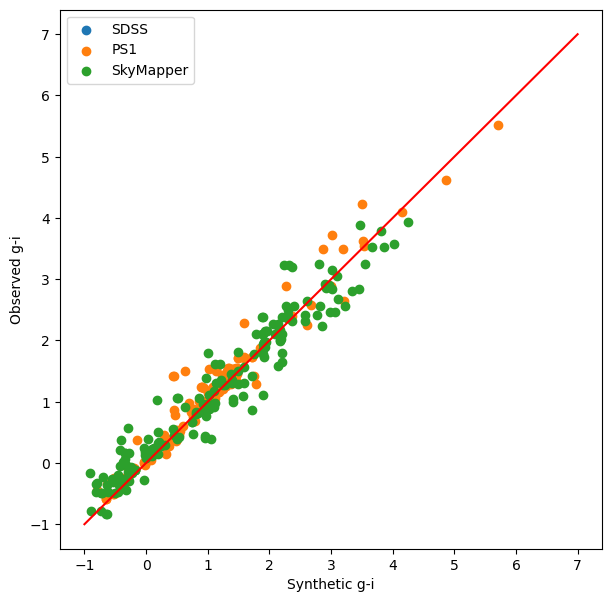

In [41]:
plt.figure(figsize=(7, 7))
plt.scatter(synth_colors[synth_colors['obs_source']=='SDSS']['gi'], synth_colors[synth_colors['obs_source']=='SDSS']['obs_g']-synth_colors[synth_colors['obs_source']=='SDSS']['obs_i'], label='SDSS')
plt.scatter(synth_colors[synth_colors['obs_source']=='PS1']['gi'], synth_colors[synth_colors['obs_source']=='PS1']['obs_g']-synth_colors[synth_colors['obs_source']=='PS1']['obs_i'], label='PS1')
plt.scatter(synth_colors[synth_colors['obs_source']=='SkyMapper']['gi'], synth_colors[synth_colors['obs_source']=='SkyMapper']['obs_g']-synth_colors[synth_colors['obs_source']=='SkyMapper']['obs_i'], label='SkyMapper')
plt.plot(np.arange(-1, 8, 1), np.arange(-1, 8, 1), c='r')
plt.xlabel('Synthetic g-i')
plt.ylabel('Observed g-i')
plt.legend(loc='best')

In [42]:
synth_colors.to_csv('xshooter_synthcolor_obs.csv', index=False)

In [43]:
df_gaia = pd.read_csv('xshooter_synthcolor_obs_gaia.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


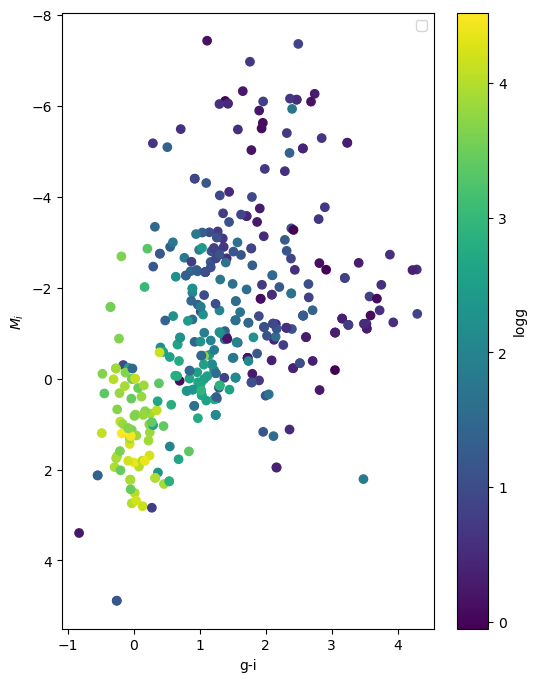

In [44]:
fig, ax = plt.subplots(figsize=(6, 8))
cb = plt.scatter(df_gaia['obs_g']-df_gaia['obs_i'], df_gaia['obs_i']-5*np.log10(df_gaia['rgeo'])+5, c=df_gaia['logg'])
plt.colorbar(cb, label='logg')
plt.xlabel('g-i')
plt.ylabel(r'$M_i$')
plt.legend(loc='best')
plt.gca().invert_yaxis()

In [45]:
columns = np.array(synth_colors.columns)
columns= np.append(columns, 'rgeo')
df_gaia[columns].dropna().to_csv('xshooter_synthcolor_select.csv', index=False)